In [1]:
import numpy as np
import pandas as pd
import math

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import wordnet

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

<h1>Loading Dataset</h1>

In [2]:
df_train=pd.read_csv("dataset/BBC News Train.csv")
df_test=pd.read_csv("dataset/BBC News Test.csv")

<h2>PreProcessing</h2>

In [3]:
df_train.head()

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


In [4]:
df_train.isna().sum()
#No Null value exists

ArticleId    0
Text         0
Category     0
dtype: int64

In [5]:
Category_class=sorted(df_train["Category"].unique())
Category_class

['business', 'entertainment', 'politics', 'sport', 'tech']

<h3>Maping</h3>

In [6]:
mapping={'business':0, 'entertainment':1, 'politics':2, 'sport':3, 'tech':4}
df_train['CategoryId']=df_train['Category'].map(mapping)


In [7]:
df_train.sample(5)

,ArticleId,Text,Category,CategoryId
268,474,broadband steams ahead in the us more and more...,tech,4
913,1792,choose hope over fear - kennedy voters will ha...,politics,2
92,212,straw attacked on china arms moves to lift the...,politics,2
568,1765,nintendo ds aims to touch gamers the mobile ga...,tech,4
825,1050,mobiles rack up 20 years of use mobile phones ...,tech,4


In [8]:
df_train.groupby('Category').CategoryId.count()

Category
business         336
entertainment    273
politics         274
sport            346
tech             261
Name: CategoryId, dtype: int64

<h3>Visualize</h3>

<AxesSubplot:xlabel='Category'>

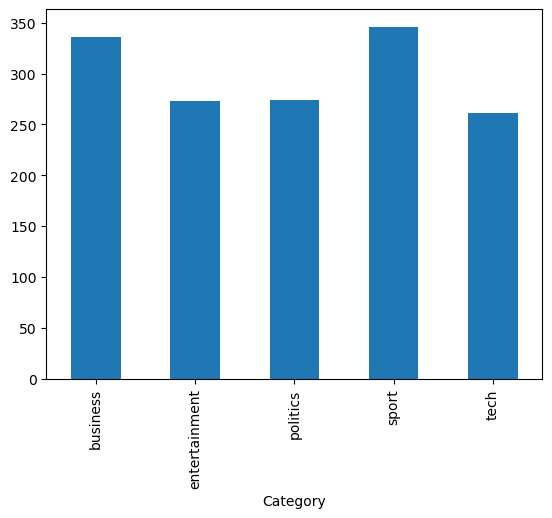

In [9]:
df_train.groupby('Category').CategoryId.count().plot.bar()

In [10]:
df_train["Text"].sample(5)

1102    no uk premiere for rings musical the producers...
487     takeover offer for sunderland fc bob murray  c...
1366    business fears over sluggish eu economy as eur...
552     what s next for next-gen consoles  the next ge...
831     uk troops on ivory coast standby downing stree...
Name: Text, dtype: object

<h3>PreProcessing Text</h3>

In [11]:
def ProcessText(text):
    text=str(text)
    #lowercasing
    text=text.lower()
    #Remove Stop Words
    stop_words=set(stopwords.words('english'))
    word_tokens = word_tokenize(text)
    filtered_list = [w for w in word_tokens if not w in stop_words]
    
    
    #Remove numbers and special Symbols
    #words like 100m 2m were not removed so using this
    num=['0','1','2','3','4','5','6','7','8','9']
    num_filter=[]
    for i in range(0,len(filtered_list)):
        for j in range(0,len(num)):
            if num[j] in filtered_list[i]:
                num_filter.append(filtered_list[i])
                break
    
    for filter in num_filter:
        filtered_list.remove(filter)
                
    filtered_list = [w for w in filtered_list if w.isalnum()]
    filtered_list=  [w for w in filtered_list if not w.isdigit()]
    
    
    
    #Lematizing
    wordnet_lemmatizer=WordNetLemmatizer()
    lemmatized_list=[wordnet_lemmatizer.lemmatize(w,wordnet.VERB) for w in filtered_list]
    lemmatized_string=' '.join(lemmatized_list)
    
    return lemmatized_string

In [12]:
print(ProcessText("Hey studys car's my, mountaining guidings going went better is Bibek's Thapa $ 45d"))

hey study car mountaining guide go go better bibek thapa


<h3>Analyzing Processed Text</h3>

In [13]:
def rand():
    return np.random.binomial(n=1,p=0.01,size=[1])
def count_word(word):
    cnt=word.count(" ")+1
    return cnt
count=0
for i in range(0,len(df_train)):
    if rand():
        txt=df_train['Text'][i]
        processed_txt=ProcessText(df_train['Text'][i])
        
        print(txt+'\n \n'+processed_txt)
        print(f"\nMain Text Word Count : {count_word(txt)}\nProcessed Text Word Count : {count_word( processed_txt)}")
        count+=1
    if count==1:
        break
    

worldcom boss  left books alone  former worldcom boss bernie ebbers  who is accused of overseeing an $11bn (£5.8bn) fraud  never made accounting decisions  a witness has told jurors.  david myers made the comments under questioning by defence lawyers who have been arguing that mr ebbers was not responsible for worldcom s problems. the phone company collapsed in 2002 and prosecutors claim that losses were hidden to protect the firm s shares. mr myers has already pleaded guilty to fraud and is assisting prosecutors.  on monday  defence lawyer reid weingarten tried to distance his client from the allegations. during cross examination  he asked mr myers if he ever knew mr ebbers  make an accounting decision  .  not that i am aware of   mr myers replied.  did you ever know mr ebbers to make an accounting entry into worldcom books   mr weingarten pressed.  no   replied the witness. mr myers has admitted that he ordered false accounting entries at the request of former worldcom chief financia

<h3>Apply Process Text in our column </h3>

In [14]:
df_train['Text']=df_train['Text'].apply(ProcessText)

<h3>Transforming Text to Vectors for MultiClassification </h3>

In [15]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,ngram_range=(1,2))
features = tfidf.fit_transform(df_train['Text']).toarray()
features

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

<h3>Displaying highly correlated words in categories </h3>

In [16]:
N = 5
category_id_df = df_train[['Category', 'CategoryId']].drop_duplicates()
category_id=dict(category_id_df.values)
labels=df_train['CategoryId']

for Category, category_id in sorted(category_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names_out())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print(f"Category : {Category}")
  print(f"    Most Correlated Unigrams  :  {(', '.join(unigrams[-N:]))}")
  print(f"    Most Correlated Bigrams   :  {(', '.join(bigrams[-N:]))}")
  print("")

Category : business
    Most Correlated Unigrams  :  economy, profit, oil, growth, bank
    Most Correlated Bigrams   :  interest rat, oil price, stock market, economic growth, analysts say

Category : entertainment
    Most Correlated Unigrams  :  album, actor, award, star, film
    Most Correlated Bigrams   :  film festival, name best, best film, los angeles, box office

Category : politics
    Most Correlated Unigrams  :  minister, party, blair, election, labour
    Most Correlated Bigrams   :  mr brown, general election, prime minister, tony blair, mr blair

Category : sport
    Most Correlated Unigrams  :  chelsea, match, coach, cup, champion
    Most Correlated Bigrams   :  world cup, champion league, grand slam, australian open, six nations

Category : tech
    Most Correlated Unigrams  :  microsoft, computer, technology, software, users
    Most Correlated Bigrams   :  news website, people use, hard drive, let people, mobile phone



In [17]:
df_train.head()

,ArticleId,Text,Category,CategoryId
0,1833,worldcom launch defence lawyers defend former ...,business,0
1,154,german business confidence slide german busine...,business,0
2,1101,bbc poll indicate economic gloom citizens majo...,business,0
3,1976,lifestyle govern mobile choice faster better f...,tech,4
4,917,enron boss payout eighteen former enron direct...,business,0


<h3>Train Test Split</h3>

In [18]:
x=features
y=df_train.loc[:,'CategoryId'].values
train_x,test_x,train_y,test_y=train_test_split(x,y,test_size=0.2,random_state=100)

<h2>Hyper Tuning</h2>

In [19]:
svc=SVC()
knn=KNeighborsClassifier()
dtc=DecisionTreeClassifier()
mb=MultinomialNB()
rtc=RandomForestClassifier()

In [20]:
models={'svc':svc,'knn':knn,'dtc':dtc,'mb':mb,'rtc':rtc}

In [21]:
params={
    'knn': 
        {'n_neighbors':[3,5,7,9,11,13,15],
        'metric':['cosine','euclidean','manhattan'],
        'weights':['uniform','distance']},
    
    'svc': {'C':[0.1,1,10,100], 
            'gamma':[1,0.1,0.01,0.01], 
            'kernel':['rbf','linear']},
    
    'dtc':{
        'criterion':['gini','entropy'],
        'max_depth':[2,4,6,8,10,12]
    },
    
    'mb':{
        'alpha': [1.0,2.0],
    'fit_prior': [True]
    },
    'rtc':{
        'criterion':['gini','entropy'],
        'max_depth':[2,4,6,8,10,12]
    }
}

In [22]:
model_accuracy={}
score=0.0001
for model in models.keys():
    mod = GridSearchCV(
    models[model],
    params[model],
    verbose=0, #Progress bar showing
    cv=5, #cross validation
    n_jobs=-1, #cores to assign
)
    gridsearch_result=mod.fit(train_x,train_y)
    
    #selects best model
    if(score < float(gridsearch_result.score(test_x,test_y))):
            score=gridsearch_result.score(test_x,test_y)
            best_model=gridsearch_result
            
    predict=mod.predict(test_x)
    print(f"{model} : ",gridsearch_result.best_estimator_)
    if model not in model_accuracy.keys():
        model_accuracy.update({model:accuracy_score(test_y,predict)})

svc :  SVC(C=10, gamma=1, kernel='linear')


c:\Users\Ghost\anaconda3\envs\class\lib\site-packages\sklearn\model_selection\_search.py:953: UserWarning: One or more of the test scores are non-finite: [0.95554657 0.95470975 0.95134489 0.95302908 0.95554657 0.95638339
 0.96476566 0.96308498 0.96728315 0.96476917 0.96560599 0.96644281
 0.96225168 0.96392532        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan]
  warnings.warn(


knn :  KNeighborsClassifier(metric='cosine', n_neighbors=11)
dtc :  DecisionTreeClassifier(criterion='entropy', max_depth=10)
mb :  MultinomialNB()
rtc :  RandomForestClassifier(criterion='entropy', max_depth=10)


In [23]:
model_accuracy

{'svc': 0.9798657718120806,
 'knn': 0.9563758389261745,
 'dtc': 0.738255033557047,
 'mb': 0.9563758389261745,
 'rtc': 0.9261744966442953}

In [24]:
print(best_model.best_estimator_)
best_model.best_score_

SVC(C=10, gamma=1, kernel='linear')


0.9823775535318731

In [25]:
test_predict = best_model.predict(test_x)
train_accuracy = round(best_model.score(train_x,train_y)*100)
test_accuracy =round(accuracy_score(test_predict, test_y)*100)

print(f"Train Accuracy Score : {train_accuracy}")
print(f"Test Accuracy Score  : {test_accuracy}")
print()
print(classification_report(test_predict, test_y, target_names=Category_class))

Train Accuracy Score : 100
Test Accuracy Score  : 98

               precision    recall  f1-score   support

     business       1.00      0.98      0.99        65
entertainment       0.95      0.98      0.97        57
     politics       0.95      0.98      0.97        59
        sport       1.00      1.00      1.00        61
         tech       1.00      0.95      0.97        56

     accuracy                           0.98       298
    macro avg       0.98      0.98      0.98       298
 weighted avg       0.98      0.98      0.98       298



<h3>Predicting Text by Converting Text to Rough Tf-IDF</h3>


<h3>IDF Calculation</h3>

In [229]:

def calc_idf(Text_column):
    col=tfidf.get_feature_names_out()
    doc_count=len(Text_column)
    df={}
    idf={}
    for char in col:
        df[char]=0
        idf[char]=0
    #Calculating df
    for i in range(0,len(col)):
        for j in range(0,len(Text_column)):
            if col[i] in Text_column[j]:
                df[col[i]]+=1
    #Calculating idf
    for char in col:
        idf[char]=math.log((doc_count+1)/(1+df[char]))+1
    return(idf)

idf=calc_idf(df_train['Text'])


<h3>Above cell takes time to run so saving idf values as text For using Flask Operation</h3>

In [231]:
import ast
with open('backend/idf.txt', 'w') as f:
    print(idf, file=f)
with open('backend/idf.txt') as f:
     idf_load=f.read()
idf_load=ast.literal_eval(idf_load)

<h3>TF-IDF Calculation</h3>

In [ ]:

def calc_tf_idf(txt,idf):
    idf=idf
    
    tf_idf={}
    word_count={}
    col=tfidf.get_feature_names_out()
    for ch in col:
        tf_idf[ch]=0
        word_count[ch]=0
    #Calculating tf
    words = txt.split()
    for ch in words:
        if ch in col:
            if ch in word_count:
                word_count[ch] += 1
            else:
                word_count[ch] = 1
   
    rough_tfidf=list(col)
    for keys in word_count.keys():
        tf_idf[keys]=idf[keys]*word_count[keys]
        if keys in rough_tfidf:
            index=rough_tfidf.index(keys)
            rough_tfidf[index]=tf_idf[keys]
    norm=0
    for i in range(0,len(rough_tfidf)):
        norm+=rough_tfidf[i]**2
    if norm==0:
        norm=1
    for i in range(0,len(rough_tfidf)):
        rough_tfidf[i]=round(rough_tfidf[i]/math.sqrt(norm),8)
    return rough_tfidf


In [210]:
#For Visualizing
arr=calc_tf_idf(" abandon abandon abandon  so abc abc  ability",idf)
print(tfidf.get_feature_names_out()[0:5])
print(arr[0:5])    

['abandon' 'abbott' 'abc' 'abilities' 'ability']
[0.79468882, 0.0, 0.58486493, 0.0, 0.16248907]


In [211]:
def Predict_text(txt):
    #process text
    text=ProcessText(txt)
    #calculate tfidf
    tf_idf=calc_tf_idf(txt,idf)
    #Validate if it is actually news
    if all(i > 0.05 for i in tf_idf) or count_word(txt)<100:
        print("Cannot classify")
    else:
        tf_idf_2=calc_tf_idf(" ",idf)
        tf_idf=np.append(tf_idf,tf_idf_2,axis=0)
        tf_idf=tf_idf.reshape(2,-1)
        #Predicting
        index=model.predict(tf_idf[0:1])
        print(Category_class[int(index)])

In [212]:
Predict_text("fox  too reliant on reality tv  the head of us tv network fox has admitted the broadcaster had relied too heavily on reality tv shows such as the poor-rating who s your daddy.  chief executive gail berman said  in the case of this fall we drifted to too much on the unscripted side . the series who s your daddy  where a young woman tries to pick her natural father for a cash prize caused outrage from adoption groups and rated badly. last season  fox s prime-time audience fell by 600 000 to 5.9 million. ms berman said:  i think the audience expects loud things from fox. sometimes they work  and sometimes they don t.   who s your daddy  the first episode of which was shown on 3 january  pulled in a disappointing audience of 6.3 million  according to the nielsen ratings system. five other episodes of the show had also been filmed will be dropped from fox s schedules  ms berman said. she was predicting a drop in ratings even for some of the network s established reality shows  such as american idol  which is due to start its fourth series this week. fox had unveiled a new strategy last year promising to launch new shows every season  including the traditionally quiet summer season. though that had met with a poor reception  ms berman said  there s no question that the audience  in our mind  is ready  willing and able to accept new programming in the summer . fox has changed this plan  launching new shows in may instead of june. one of the new shows will be the animated series american dad  made by seth macfarlane  the creator of family guy. that series  after becoming a hit on dvd  is also set to return with new episodes.")

entertainment


In [213]:
Predict_text("qpr keeper day heads for preston queens park rangers keeper chris day is set to join preston on a month s loan.  day has been displaced by the arrival of simon royce  who is in his second month on loan from charlton. qpr have also signed italian generoso rossi. r s manager ian holloway said:  some might say it s a risk as he can t be recalled during that month and simon royce can now be recalled by charlton.  but i have other irons in the fire. i have had a  yes  from a couple of others should i need them.   day s rangers contract expires in the summer. meanwhile  holloway is hoping to complete the signing of middlesbrough defender andy davies - either permanently or again on loan - before saturday s match at ipswich. davies impressed during a recent loan spell at loftus road. holloway is also chasing bristol city midfielder tom doherty.")

sport


In [214]:
Predict_text("eu referendum question unveiled the question to be asked in the referendum on the eu constitution has been unveiled by the government.  it will be:  should the united kingdom approve the treaty establishing a constitution for the european union   the constitution will be incorporated into uk law if there is a yes vote in the referendum  expected in 2006. critics say the constitution is a further step towards a federal europe  but advocates say it ensures effective operation of the enlarged 25-state eu.  if we reject this treaty  britain will be isolated and weak in europe   said foreign secretary jack straw  who along with the rest of the cabinet  will back a  yes  vote.  patriots by definition wanted the uk to be prosperous at home and strong and influential abroad  mr straw said.  our role as a leading member of the eu is a crucial part of securing that.   conservative shadow foreign secretary michael ancram said the referendum question  seems straightforward . but he accused the government of trying to confuse the issue by putting the eu referendum question in the same bill as the ratification of the constitution  when they should be treated as  two separate issues . despite this  underhand trick   the referendum bill stood  no chance of becoming law before the election   he added.  this is tony blair s cheap gesture to the pro-constitution lobby while he runs scared of a debate on europe he knows he cannot win.  neil o brien  director of anti-constitution group vote no  said:  the reality is that the government doesn t want to discuss the eu constitution ahead of the election because they know it is extremely unpopular with voters and with business.   the uk independence party said:  if the government believes that a no vote would mean that we should leave the european union  they should just ask us if we want to leave the eu. then we can be out of it and better off much sooner.   liberal democrat leader charles kennedy  who backs the constitution  said he expected the referendum would come in the first half of next year. he told bbc radio 4 s today programme:  the sooner we get on with this  the better.  he said the question sounded  very neutral  and  balanced   adding it would enable the argument  to be enjoined fairly and squarely on both sides . green mep caroline lucas welcomed tony blair s  courage in keeping his word  on holding a referendum. but she added:  this treaty is a flawed document that will make the eu less accountable  less sustainable  and less just.   mr blair signed the constitution at a ceremony in rome in november  but had already made it clear the issue would be put to voters in a referendum. that promise came after sustained pressure from opposition parties. jack straw  who argues the constitution reflected a  british vision for europe  and gives  national governments a stronger grip   has said the referendum could be held in spring 2006. but in an interview with the financial times  mr blair refused to be pinned down to that date  saying britain would hold a poll  some time in 2006 but when  i don t know . the paper said the prime minister  claimed ignorance  of when other countries were planning to hold their referendums.")

politics


In [215]:
Predict_text("french consumer spending rising french consumers increased their spending by 1.5% in january  a figure which bodes well for the country s economic growth  figures revealed.  the national statistic institute (insee) added that consumer spending in january rose 3.8% on a year-on-year basis. rising sales of household equipment were behind the increase. the insee also said that french consumer prices fell 0.6% in january  but were up 1.6% on an annual basis.  despite the general increase in spending in january  french households bought fewer cars in january. according to the insee  car sales fell 2.8% in january  following a fall of 0.6% in december. but on a year-on-year basis  the sector still saw a sales increase of 6.5%. consumer spending fuelled france s economic growth in the last quarter of 2004 and analysts expect that it will continue to support the economy.  it s a growth that will remain fragile and vulnerable to risks like a strong rise in long-term interest rates  tension in the oil price   emmanuel ferry  from exane bnp paribas told reuters news agency.  meanwhile in italy  consumer confidence rose to its highest level since october 2004. economic research group isae has said that italian consumer confidence rose to 104.4 from 103.3  despite a slight deterioration in short-term sentiment.")

business


In [216]:
Predict_text("search sites get closer to users search sites want to get to know you better.  not content with providing access to the millions of websites  many now offer ways that do a better job of remembering  cataloguing and managing all the information you come across. some of the latest to update their search systems are ask jeeves and blinkx  which have both released a series of utilities that try to help people get more from the web.  the future is all about developing your own personal web   said tony macklin  spokesman for ask jeeves.  mr macklin said that too often when people use a search engine it was like the first time they ever used it  because there was no memory of what they had searched for before.  each time you go back in you have to start all over again   he said. the series of updates to its service  collected under the my ask jeeves banner  would help people remember where they had been before.  ask jeeves has added the ability to  save  websites of interest so the next time a users visits the site they can search through the sites they have previously found. sites saved in this way can be arranged in folders and have notes attached to them to explain why they were saved. mr macklin said many people wanted to save sites they had seen but did not want to add them to their bookmarks or favourites not least because such lists cannot be easily searched. on average  said mr macklin  users conduct between five and 10 searches per day and the tools in my ask jeeves should stop them having to do searches twice and get to what they want much more easily. under my ask jeeves users can search the web or through the results they have already noted as interesting.  it s about finding again what you found before   he said. the my ask jeeves service lets people store up to a 1000 web links or 5000 if they sign up to the free service. by way of comparison google s desktop search tool catalogues search histories informally and lets people look through the sites they have visited.  at the same time  search start-up blinkx has released a second version of its eponymous software. blinkx is desktop search software that watches what someone is working on  be it a document or e-mail  and suggests websites  video clips  blogs or documents on a pc that are relevant to it.  since blinkx launched it has faced increased competition from firms such as google  copernic  enfish  x1 and apple all of whom now have programs that let people search their pc as well as the web.  the competition has validated the problem we tackle   said suranga chandratillake  co-founder of blinkx. in the latest release of blinkx  the company has added what it calls smart folders. once created the folders act as persistent queries that automatically sweep the web for pages related to their subject and catalogues relevant information  documents or incoming e-mails  on hard drives too. what users do with blinkx and other desktop search engines shows that people tend to be very promiscuous in their use of search engines.  blinkx users do not stop using other web search systems   he said.  they might use google to look up a company  or yahoo for travel because they know they are good at that   he said.  the classic thing we have seen recently  is people using blinkx to look at the things they have searched on   he said. the variety of ways to search data was only helping users  said mr chandratillake and that it was likely that in the future people would use different ones for different tasks.")

tech


In [232]:
import joblib

In [233]:
joblib.dump(best_model,'model.pkl')

['model.pkl']

In [33]:
model=joblib.load('model.pkl')

In [191]:
def Predict_text_pickle(txt):
    #process text
    text=ProcessText(txt)
    #calculate tfidf
    tf_idf=calc_tf_idf(txt,idf)
    #Validate if it is actually news
    if all(i <.05 for i in tf_idf) or count_word(txt)<100:
        print("Cannot classify")
    else:
        tf_idf_2=calc_tf_idf(" ",idf)
        tf_idf=np.append(tf_idf,tf_idf_2,axis=0)
        tf_idf=tf_idf.reshape(2,-1)
        #Predicting
        index=model.predict(tf_idf[0:1])
        print(Category_class[int(index)])

In [189]:
Predict_text_pickle("The nepali film industry will need some lifting.")
Predict_text_pickle(" ")

Cannot classify
Cannot classify


In [192]:
Predict_text_pickle("fox  too reliant on reality tv  the head of us tv network fox has admitted the broadcaster had relied too heavily on reality tv shows such as the poor-rating who s your daddy.  chief executive gail berman said  in the case of this fall we drifted to too much on the unscripted side . the series who s your daddy  where a young woman tries to pick her natural father for a cash prize caused outrage from adoption groups and rated badly. last season  fox s prime-time audience fell by 600 000 to 5.9 million. ms berman said:  i think the audience expects loud things from fox. sometimes they work  and sometimes they don t.   who s your daddy  the first episode of which was shown on 3 january  pulled in a disappointing audience of 6.3 million  according to the nielsen ratings system. five other episodes of the show had also been filmed will be dropped from fox s schedules  ms berman said. she was predicting a drop in ratings even for some of the network s established reality shows  such as american idol  which is due to start its fourth series this week. fox had unveiled a new strategy last year promising to launch new shows every season  including the traditionally quiet summer season. though that had met with a poor reception  ms berman said  there s no question that the audience  in our mind  is ready  willing and able to accept new programming in the summer . fox has changed this plan  launching new shows in may instead of june. one of the new shows will be the animated series american dad  made by seth macfarlane  the creator of family guy. that series  after becoming a hit on dvd  is also set to return with new episodes.")

entertainment


In [193]:
Predict_text_pickle("qpr keeper day heads for preston queens park rangers keeper chris day is set to join preston on a month s loan.  day has been displaced by the arrival of simon royce  who is in his second month on loan from charlton. qpr have also signed italian generoso rossi. r s manager ian holloway said:  some might say it s a risk as he can t be recalled during that month and simon royce can now be recalled by charlton.  but i have other irons in the fire. i have had a  yes  from a couple of others should i need them.   day s rangers contract expires in the summer. meanwhile  holloway is hoping to complete the signing of middlesbrough defender andy davies - either permanently or again on loan - before saturday s match at ipswich. davies impressed during a recent loan spell at loftus road. holloway is also chasing bristol city midfielder tom doherty.")

sport


In [194]:
Predict_text_pickle("eu referendum question unveiled the question to be asked in the referendum on the eu constitution has been unveiled by the government.  it will be:  should the united kingdom approve the treaty establishing a constitution for the european union   the constitution will be incorporated into uk law if there is a yes vote in the referendum  expected in 2006. critics say the constitution is a further step towards a federal europe  but advocates say it ensures effective operation of the enlarged 25-state eu.  if we reject this treaty  britain will be isolated and weak in europe   said foreign secretary jack straw  who along with the rest of the cabinet  will back a  yes  vote.  patriots by definition wanted the uk to be prosperous at home and strong and influential abroad  mr straw said.  our role as a leading member of the eu is a crucial part of securing that.   conservative shadow foreign secretary michael ancram said the referendum question  seems straightforward . but he accused the government of trying to confuse the issue by putting the eu referendum question in the same bill as the ratification of the constitution  when they should be treated as  two separate issues . despite this  underhand trick   the referendum bill stood  no chance of becoming law before the election   he added.  this is tony blair s cheap gesture to the pro-constitution lobby while he runs scared of a debate on europe he knows he cannot win.  neil o brien  director of anti-constitution group vote no  said:  the reality is that the government doesn t want to discuss the eu constitution ahead of the election because they know it is extremely unpopular with voters and with business.   the uk independence party said:  if the government believes that a no vote would mean that we should leave the european union  they should just ask us if we want to leave the eu. then we can be out of it and better off much sooner.   liberal democrat leader charles kennedy  who backs the constitution  said he expected the referendum would come in the first half of next year. he told bbc radio 4 s today programme:  the sooner we get on with this  the better.  he said the question sounded  very neutral  and  balanced   adding it would enable the argument  to be enjoined fairly and squarely on both sides . green mep caroline lucas welcomed tony blair s  courage in keeping his word  on holding a referendum. but she added:  this treaty is a flawed document that will make the eu less accountable  less sustainable  and less just.   mr blair signed the constitution at a ceremony in rome in november  but had already made it clear the issue would be put to voters in a referendum. that promise came after sustained pressure from opposition parties. jack straw  who argues the constitution reflected a  british vision for europe  and gives  national governments a stronger grip   has said the referendum could be held in spring 2006. but in an interview with the financial times  mr blair refused to be pinned down to that date  saying britain would hold a poll  some time in 2006 but when  i don t know . the paper said the prime minister  claimed ignorance  of when other countries were planning to hold their referendums.")

politics


In [195]:
Predict_text_pickle("software watching while you work software that can not only monitor every keystroke and action performed at a pc but also be used as legally binding evidence of wrong-doing has been unveiled.  worries about cyber-crime and sabotage have prompted many employers to consider monitoring employees. the developers behind the system claim it is a break-through in the way data is monitored and stored. but privacy advocates are concerned by the invasive nature of such software.  the system is a joint venture between security firm 3ami and storage specialists bridgehead software. they have joined forces to create a system which can monitor computer activity  store it and retrieve disputed files within minutes. more and more firms are finding themselves in deep water as a result of data misuse. sabotage and data theft are most commonly committed from within an organisation according to the national hi-tech crime unit (nhtcu) a survey conducted on its behalf by nop found evidence that more than 80% of medium and large companies have been victims of some form of cyber-crime. bridgehead software has come up with techniques to prove  to a legal standard  that any stored file on a pc has not been tampered with. ironically the impetus for developing the system came as a result of the freedom of information act  which requires companies to store all data for a certain amount of time.  the storage system has been incorporated into an application developed by security firm 3ami which allows every action on a computer to be logged. potentially it could help employers to follow the trail of stolen files and pinpoint whether they had been emailed to a third party  copied  printed  deleted or saved to cd  floppy disk  memory stick or flash card. other activities the system can monitor include the downloading of pornography  the use of racist or bullying language or the copying of applications for personal use. increasingly organisations that handle sensitive data  such as governments  are using biometric log-ins such as fingerprinting to provide conclusive proof of who was using a particular machine at any given time. privacy advocates are concerned that monitoring at work is not only damaging to employee s privacy but also to the relationship between employers and their staff.  that is not the case   said tim ellsmore  managing director of 3ami.  it is not about replacing dialogue but there are issues that you can talk through but you still need proof   he said.  people need to recognise that you are using a pc as a representative of a company and that employers have a legal requirement to store data   he added.")

tech


In [197]:
Predict_text_pickle("french consumer spending rising french consumers increased their spending by 1.5% in january  a figure which bodes well for the country s economic growth  figures revealed.  the national statistic institute (insee) added that consumer spending in january rose 3.8% on a year-on-year basis. rising sales of household equipment were behind the increase. the insee also said that french consumer prices fell 0.6% in january  but were up 1.6% on an annual basis.  despite the general increase in spending in january  french households bought fewer cars in january. according to the insee  car sales fell 2.8% in january  following a fall of 0.6% in december. but on a year-on-year basis  the sector still saw a sales increase of 6.5%. consumer spending fuelled france s economic growth in the last quarter of 2004 and analysts expect that it will continue to support the economy.  it s a growth that will remain fragile and vulnerable to risks like a strong rise in long-term interest rates  tension in the oil price   emmanuel ferry  from exane bnp paribas told reuters news agency.  meanwhile in italy  consumer confidence rose to its highest level since october 2004. economic research group isae has said that italian consumer confidence rose to 104.4 from 103.3  despite a slight deterioration in short-term sentiment.")

business
